<a href="https://colab.research.google.com/github/EliasSf73/Autism-Classification/blob/master/VAE_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

In [1]:
!wget https://www.dropbox.com/s/d1kjpkqklf0uw77/celeba.zip?dl=0

--2024-04-08 23:09:49--  https://www.dropbox.com/s/d1kjpkqklf0uw77/celeba.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/d1kjpkqklf0uw77/celeba.zip [following]
--2024-04-08 23:09:49--  https://www.dropbox.com/s/raw/d1kjpkqklf0uw77/celeba.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc78477ae96e1fe0ac3074dc5f69.dl.dropboxusercontent.com/cd/0/inline/CQqmmjQvxdCXPlIrpo1HhfWLlxAX4Rhokf6DQnmb0gifOp0VQ-AxaE9Rjsowg8U4xlzzLNx2MIfAVtb_RXyl80YJ4rusnNiNesEVExoTeZCKYZs0hVCRXY_-SYriwr5pDSkyoHKQB-2S7i3PMO3LGjT4/file# [following]
--2024-04-08 23:09:50--  https://uc78477ae96e1fe0ac3074dc5f69.dl.dropboxusercontent.com/cd/0/inline/CQqmmjQvxdCXPlIrpo1HhfWLlxAX4Rhokf6DQnmb0gifOp0VQ-AxaE9Rjsowg8U4xlzzLNx2MIfAVtb_RXyl80YJ4rusnNiNesEVExo

In [2]:
!unzip celeba.zip

Streaming output truncated to the last 5000 lines.
  inflating: celeba/images/012465.jpg  
  inflating: celeba/images/089057.jpg  
  inflating: celeba/images/147796.jpg  
  inflating: celeba/images/192463.jpg  
  inflating: celeba/images/142818.jpg  
  inflating: celeba/images/148061.jpg  
  inflating: celeba/images/184432.jpg  
  inflating: celeba/images/201157.jpg  
  inflating: celeba/images/097288.jpg  
  inflating: celeba/images/130371.jpg  
  inflating: celeba/images/082864.jpg  
  inflating: celeba/images/017429.jpg  
  inflating: celeba/images/186077.jpg  
  inflating: celeba/images/126843.jpg  
  inflating: celeba/images/200381.jpg  
  inflating: celeba/images/012555.jpg  
  inflating: celeba/images/092238.jpg  
  inflating: celeba/images/008151.jpg  
  inflating: celeba/images/171418.jpg  
  inflating: celeba/images/155589.jpg  
  inflating: celeba/images/032110.jpg  
  inflating: celeba/images/098319.jpg  
  inflating: celeba/images/011702.jpg  
  inflating: celeba/images/17

# Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# from torchvision.datasets import CelebA
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
# from models import VAE
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        # Assume CelebA images are preprocessed to 64x64 pixels
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)  # 32x32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  # 16x16
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 8x8
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # 4x4
        self.flatten = nn.Flatten()  # Flatten the convolutional layer output
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)  # Fully connected layer for mean
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)  # Fully connected layer for std

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.conv_trans1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.conv_trans2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv_trans3 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.conv_trans4 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 128, 4, 4)  # Reshape z to the initial size before the convolutional layers
        z = F.relu(self.conv_trans1(z))
        z = F.relu(self.conv_trans2(z))
        z = F.relu(self.conv_trans3(z))
        z = torch.sigmoid(self.conv_trans4(z))  # Output layer with sigmoid activation
        return z
class VAE(nn.Module):
    def __init__(self,latent_dim):
        super(VAE,self).__init__()
        self.encoder=Encoder(latent_dim)
        self.decoder=Decoder(latent_dim)
    def reparametrize(self,mu,logvar):
        """
        Applies the reparameterization trick: z = mu + sigma * epsilon,
        where epsilon is sampled from a standard normal distribution.
        """
        std = torch.exp(0.5 * logvar)  # sigma = exp(0.5 * log_var), for numerical stability


        epsilon = torch.randn_like(std)  # Sample epsilon from a standard normal distribution
        z = mu + std * epsilon  # Reparameterize to get z
        return z
    def forward(self, x):
        """
        Defines the forward pass of the VAE.
        """
        mu, log_var = self.encoder(x)  # Encode input to get mu and log_var
        z = self.reparametrize(mu, log_var)  # Reparameterize to get latent vector z
        return self.decoder(z), mu, log_var


# Train

Train Epoch: 1 [0/202599 (0%)]	Loss: 1163.785889
Train Epoch: 1 [6400/202599 (3%)]	Loss: 659.845093
Train Epoch: 1 [12800/202599 (6%)]	Loss: 331.330872
Train Epoch: 1 [19200/202599 (9%)]	Loss: 246.740204
Train Epoch: 1 [25600/202599 (13%)]	Loss: 273.678619
Train Epoch: 1 [32000/202599 (16%)]	Loss: 201.376663
Train Epoch: 1 [38400/202599 (19%)]	Loss: 189.707382
Train Epoch: 1 [44800/202599 (22%)]	Loss: 196.150208
Train Epoch: 1 [51200/202599 (25%)]	Loss: 179.323395
Train Epoch: 1 [57600/202599 (28%)]	Loss: 167.117477
Train Epoch: 1 [64000/202599 (32%)]	Loss: 169.737961
Train Epoch: 1 [70400/202599 (35%)]	Loss: 144.957748
Train Epoch: 1 [76800/202599 (38%)]	Loss: 146.580383
Train Epoch: 1 [83200/202599 (41%)]	Loss: 131.295334
Train Epoch: 1 [89600/202599 (44%)]	Loss: 141.929718
Train Epoch: 1 [96000/202599 (47%)]	Loss: 136.476700
Train Epoch: 1 [102400/202599 (51%)]	Loss: 141.602478
Train Epoch: 1 [108800/202599 (54%)]	Loss: 133.572815
Train Epoch: 1 [115200/202599 (57%)]	Loss: 130.11788

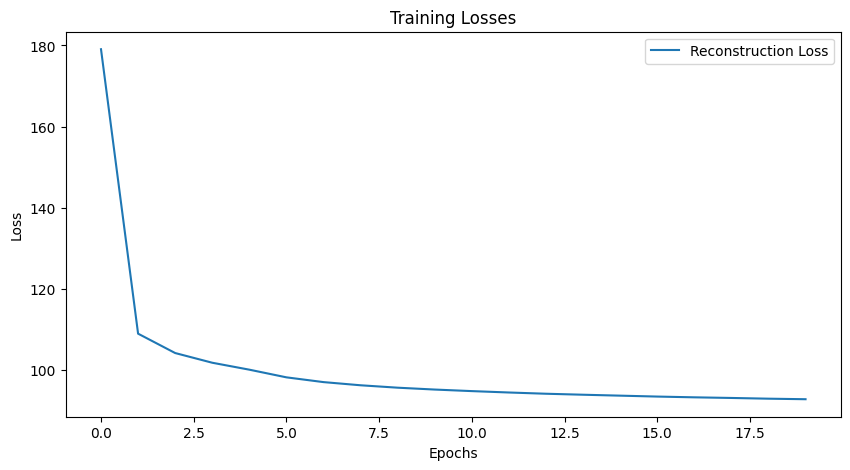

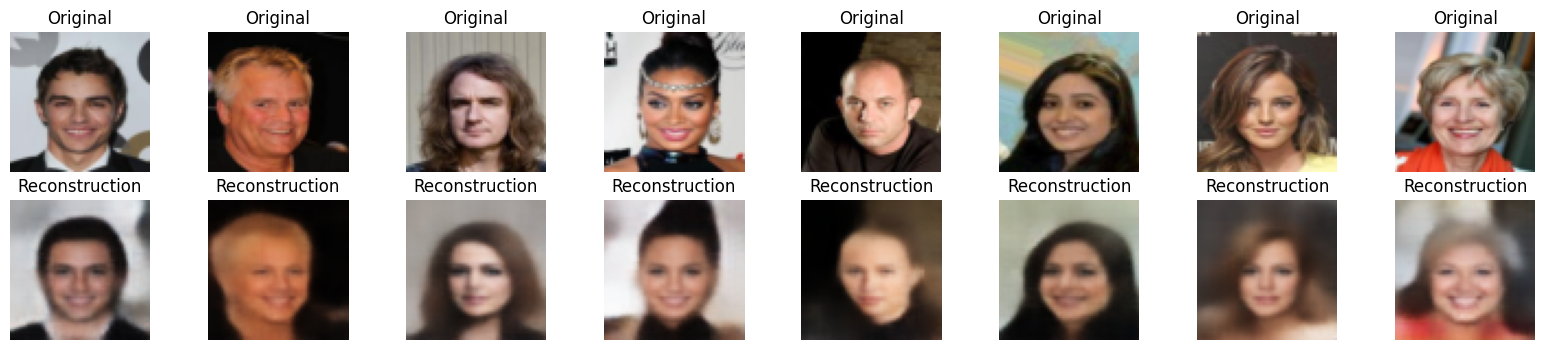

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
# from models import VAE
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
# from models import VAE
from sklearn.model_selection import train_test_split




            #CIFAR10  train=True instead of split='train'

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# the hyperparameters
batch_size = 64
epochs = 20
latent_dim = 64
learning_rate = 1e-3
lambda_ = 1

# Download the CelebA dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),        # Convert images to PyTorch tensors
])
#celeba_dataset=datasets.CelebA(root='./celeba/images', split='train', download=False, transform=transform)
# celeba_dataset = datasets.CelebA(root='/content/celeba', split='train', download=False, transform=transform)
celeba_dataset = datasets.ImageFolder('/content/celeba', transform=transform)

# Create a DataLoader for the CelebA dataset
train_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=True)


# Initialize VAE model and optimizer
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# List to track Loss
recon_losses = []
kl_losses = []

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        # data = data + torch.randn()
        optimizer.zero_grad()
        reconstruction, mu, log_var = model(data)
        recon_loss = F.mse_loss(reconstruction, data, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + (kl_loss * lambda_ / batch_size)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    avg_recon_loss = train_loss / len(train_loader.dataset)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(kl_loss.item() / len(train_loader.dataset))
    print(f'====> Epoch: {epoch} Average loss: {avg_recon_loss:.4f}')

# Plotting the losses after training
def visualize_training_loss():
    plt.figure(figsize=(10,5))
    plt.title("Training Losses")
    plt.plot(recon_losses, label="Reconstruction Loss")
    # plt.plot(kl_losses, label="KL Divergence")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def visualize_reconstructions():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(train_loader))
        data = data.to(device)
        reconstruction, _, _ = model(data)
        data = data.cpu()
        reconstruction = reconstruction.cpu()

        # Display original and reconstructed images
        num_images = 8
        fig, axs = plt.subplots(2, num_images, figsize=(20, 4))
        for i in range(num_images):
            axs[0, i].imshow(np.transpose(data[i].numpy(), (1, 2, 0)))
            axs[0, i].set_title('Original')
            axs[1, i].imshow(np.transpose(reconstruction[i].numpy(), (1, 2, 0)))
            axs[1, i].set_title('Reconstruction')
            axs[0, i].axis('off')
            axs[1, i].axis('off')
        plt.show()

for epoch in range(1, epochs + 1):
    train(epoch)

torch.save(model.state_dict(), 'vae_model.pth')


visualize_training_loss()
visualize_reconstructions()